## Implementation of the Three Models
The three approximate SRES scenarios chosen will be used to develop Bayesian temperature change prediction. The model of global temperatures $T$ as a function of $\textrm{CO}_2 (C)$ is, 
```{math} 
:temp_co2_model:
T(C) = T_0 + S \log_2(C/C_0).
```
$S$ describes the sensitivity of the global temperature to doubling in $\textrm{CO}_2$ concentration. This parameter has proved challenging to estimate given the complexity of the systems influencing global temperature Change. A PDF of $S$, $P(S)$ was produced by Sherwood et al.{ref}`S20` and will be used for our future temperature predictions and approximations of the SRES scenarios. The PDF of temperature change can be written as 
```{math}
P(\Delta T) = \int P(\Delta T|S) P(S) dS.
```
```{note}
In this model Radiative Forcing is neglected, this id the phenomenon which describes the global flux inbalance. Where more enenrgy is being let out than let in. This is a key part of the global temperature rise equation as this is not a constant factor when global temperatures rise. For a more thourough predictive with radiative forcing see [Sherwood2022](https://iopscience.iop.org/article/10.1088/1748-9326/ac6ff6){ref}`probabilityofwarming`.
```
The quantity $P(\Delta T|S)$ can be calculated using our simple climate model eq.{eq}`temp_co2_model`. 

The model will have three separate cases. As discussed before they are as follows:
- A1B) Continued growth in emission Rates.
- A1T) Net-zero by 2030, no further reductions. 
- B1) Net-zero by 2030, and then reducing total atmospheric carbon at the same rate it is currently produced.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dur_utils import colours
from scipy.optimize import curve_fit
import matplotlib as mpl

mpl.style.use('../matplotlibrc')

In [22]:
# Loading fits
model_fit = pd.read_csv('../output_files/co2_model_parameters.csv',
    index_col=0,
    ).squeeze("columns")
model_error = pd.read_csv('../output_files/co2_model_parameters_errors.csv',
    index_col=0,
    ).squeeze("columns")
#select only polynomials
poly_fit = model_fit[['c', 'p_1', 'p_2', 'p_3']]
poly_error = model_error[['c', 'p_1', 'p_2', 'p_3']]
# Loading Moving average Data
path = "http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_complete.txt"
#Formatting be data
colnames=['year', 'month', 'monthly_anomaly', 'monthly_anomaly_unc',
    'yearly_anomaly', 'yearly_anomaly_unc', '5yearly_anomaly',
    '5yearly_anomaly_unc', '10yearly_anomaly', '10yearly_anomaly_unc',
    '20yearly_anomaly', '20yearly_anomaly_unc'
    ]
temp_data = pd.read_fwf(path, skiprows=34, names=colnames)
temp_data['dt'] = temp_data['month']/12 + temp_data['year']
#remove be moving averages
temp_data.drop( columns=['yearly_anomaly', 'yearly_anomaly_unc',
    '5yearly_anomaly', '5yearly_anomaly_unc', '10yearly_anomaly',
    '10yearly_anomaly_unc', '20yearly_anomaly', '20yearly_anomaly_unc'],
    inplace=True
    )

## $\textrm{CO}_2$ Concentration Models
In the final part of [Chapter 1](Chapter_1/Final_Model.ipynb), a polynomial model with a trigonometric addition was developed to characterize the Mauna Loa $\textrm{CO}_2$ concentration, which closely follows the global average trend. Using the model without the trigonometric terms will be the basis for this section. However, it is worth noting that with polynomial functions


In [24]:
def simple_climate_model(C: pd.DataFrame, S: int, C_0: int, T_0: int) -> pd.DataFrame:
    ''' Model fuction for Temperature and CO_2 relationship.'''
     #Placeholder till I figure out what I am going to 
    return T_0 + np.log2(C/C_0)*S 

# Legacy Functions to have remove imput tag
def lb_ub(values, sigma, factor=1):
    lb = values - sigma*factor
    ub = values + sigma*factor
    return lb, ub

def a1t(x, p_0, p_1, p_2, p_3, translation=0):
    emissions_stop = np.where(x + translation >= 2030)[0]
    f_eval = p_0 + p_1*x + p_2*x**2 + p_3*x**3
    f_eval[emissions_stop[0]:] = f_eval[emissions_stop[0]-1]
    return f_eval

def B1(x, p_0, p_1, p_2, p_3, translation=0):
    emissions_stop = np.where(x + translation >= 2030)[0]
    f_eval = p_0 + p_1*x + p_2*x**2 + p_3*x**3
    f_neg =  2*f_eval[emissions_stop[0]-1] - p_0 - (p_1*x + p_2*x**2 + p_3*x**3)
    f_eval[emissions_stop[0]-1:] = f_neg[emissions_stop[0]-1:]
    return f_eval

def P3(x, p_0, p_1, p_2, p_3):
    return p_0 + p_1*x + p_2*x**2 + p_3*x**3

### The Problem with Polynomials
Problems arise when fitting polynomials of order greater than one, minor parameter tweaks to the higher powers' constants cause large deviations in the value of the function. By translating the data so that the midpoint is approximately zero, the two sigma confidence interval does not deviate as quickly. Alternatively a natural spline fit could be used to model the behavior of the moving average. This is a polynomial fit, often of the third order, in which different polynomial coefficients are used for different dependent variable ranges. Further, in a natural spline fit beyond the range of the data, the fitted function is a line fit, with a continuous gradient and value at the training data boundary. 

In [65]:
df = pd.DataFrame(abs(poly_fit/poly_error))
df.columns = ['Fit_Value/Error']
df

,Fit_Value/Error
c,1.316945e+14
p_1,8.119500e+13
p_2,1.148404e+01
p_3,1.160116e+01


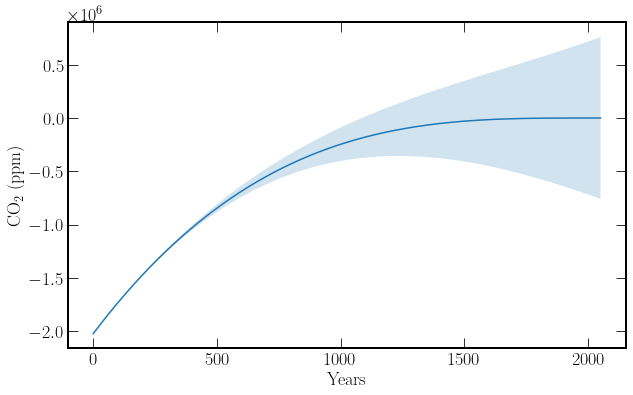

In [66]:
#time = np.linspace(temp_data['dt'].iloc[-1], 2050, 1000)
time = np.linspace(0,2050,1000)
lb_coef, ub_coef = lb_ub(poly_fit, poly_error)
plt.figure(figsize=(10, 6))
plt.plot(time, P3(time, *poly_fit))
plt.fill_between(time, P3(time, *lb_coef), P3(time, *ub_coef),alpha=0.2)
plt.ylabel(r'$\textrm{CO}_2$ (ppm)')
plt.xlabel('Years');


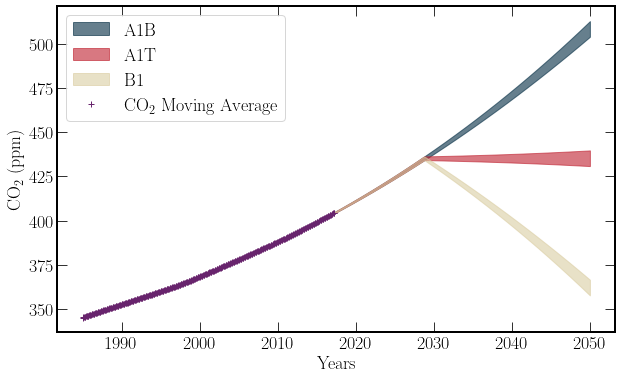

In [161]:
co2_ave = pd.read_csv('../output_files/co2_10_moving_average.csv',
    header=0,index_col=0
    )
co2_std = pd.read_csv('../output_files/co2_10_moving_std.csv', header=0,
    index_col=0
    )
co2_mov_fit, co2_mov_cov = curve_fit(P3, co2_ave['decimal']-2000,
    co2_ave['average'], sigma=co2_std['average']
    )
co2_mov_error = np.diagonal(co2_mov_cov)**0.5
co2_lb_mov, co2_ub_mov = lb_ub(co2_mov_fit, co2_mov_error, factor=2)
sigma = P3(time, *co2_ub_mov) - P3(time, *co2_mov_fit)
time = np.linspace(1985, 2050)-2000
plt.figure(figsize=(10, 6))
plt.fill_between(time, P3(time, *co2_lb_mov), P3(time, *co2_ub_mov),
    color=colours.durham.ink,
    alpha=0.6,
    label='A1B'
    )
plt.fill_between(time, a1t(time, *co2_mov_fit, translation=2000) - sigma,
    a1t(time, *co2_mov_fit,translation=2000) + sigma,
    color=colours.durham.red,
    alpha=0.6,
    label='A1T'
    )
plt.fill_between(time, B1(time, *co2_mov_fit, translation=2000)- sigma,
    B1(time, *co2_mov_fit, translation=2000) + sigma,
    color=colours.durham.stone,
    alpha=0.6,
    label='B1'
    )
plt.plot(co2_ave['decimal']-2000, co2_ave['average'],
    linestyle='',
    marker='+',
    color=colours.durham.purple,
    label=r'$\textrm{{CO}}_2$ Moving Average'
    )
plt.xticks(range(-10, 60, 10), range(1990, 2060, 10))
plt.legend(loc = 'upper left')
plt.xlabel('Years')
plt.ylabel(r'$\textrm{{CO}}_2$ (ppm)');

```{sidebar}
The Plot on the left-hand side is a quantitive representation of the simplified SRES Scenarios detailed earlier. It shows three possible future pathways and the current 10-year moving average from which the A1B fit was performed. It should be noted that these are in no way linked to anything more than common sense. And the predictive power they bring to bear is incredibly small. The purpose of these plots is to aid in the Bayesian analysis. 

The shaded areas of the Graph correspond to two standard deviations of the fitting parameters. Assuming that the errors on the fits are normally distributed, each $\textrm{CO}_2$ concentration in future time can be characterized by a random variable $C$ for the specific model, 
$$
C_{A1T} \sim \mathcal{N}(A1T(T), \sigma_{A1T}(T)).
$$
Where $A1T(T)$ is the A1T scenario function evaluated at some time $T$ and $\sigma_{A1T}(T)$ is the associated error on the fit. By treating the $\textrm{CO}_2$ concentration in future as a random variable we can use its PDF in conjuntion with the PDF of S to perform Bayesian interference on how likely crossing a temperature Threshold is. 
```